In [1]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch3d
from tensorboardX import SummaryWriter

from co3d.dataset.dataset_zoo import dataset_zoo
from co3d.dataset.dataloader_zoo import dataloader_zoo

from network.model import NerFormer
from network.feature_network import FeatureNet

from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler
from rendering import render_rays, render_image

In [2]:
torch.cuda.empty_cache()

!nvidia-smi

Tue Nov 30 22:13:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:60:00.0 Off |                  N/A |
| 27%   27C    P5    17W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def data_to_frame(co3d_data, device, tgt_idx, src_idxs):
    imgs = co3d_data.image_rgb.to(device)
    img_paths = co3d_data.image_path
    masks = co3d_data.fg_probability.to(device)
    camera = co3d_data.camera.to(device)

    target = {}
    target["rgb"] = imgs[tgt_idx]
    target["rgb_path"] = img_paths[tgt_idx]
    target["mask"] = masks[tgt_idx]
    target["camera"] = camera
    # 현재 타겟 카메라의 위치를 기준으로
    # 샘플링할 ray들의 depth range 계산
    target_camera_position = camera.get_camera_center()[tgt_idx]
    near = torch.norm(target_camera_position) - 8
    far = torch.norm(target_camera_position) + 8
    depth_range =  torch.tensor([near, far], dtype=torch.float32)
    target["depth_range"] = depth_range

    srcs = {}
    srcs["rgb"] = imgs[src_idxs]
    srcs["mask"] = masks[src_idxs]

    return target, srcs

In [25]:
chunk_size = 800*4

def log_view_to_tensorboard(writer, global_step, model, ray_sampler, srcs, src_idxs, gt_img,
                   render_stride=1, prefix=''):
    model.eval()

    with torch.no_grad():
        # 이미지의 모든 픽셀에 대해 정의된 ray batch 생성.
        ray_batch = ray_sampler.get_all()

        output = render_image(ray_sampler=ray_sampler,
                            ray_batch=ray_batch,
                            src_idxs=src_idxs,
                            model=model,
                            feature_maps=feature_maps,
                            chunk_size=chunk_size,
                            N_samples=N_s,
                            PE=PE,
                            inv_uniform=False,
                            det=True,
                            N_importance=N_importance,
                            render_stride=render_stride,
                            )

    # average_im = ray_sampler.src_rgbs.cpu().mean(dim=(0, 1))
    average_im = srcs["rgb"].cpu().mean(dim=0)

    if render_stride != 1:
        gt_img = gt_img[::render_stride, ::render_stride]
        average_im = average_im[::render_stride, ::render_stride]

    img_HWC2CHW = lambda x: x.permute(2, 0, 1)
    
    rgb_gt = img_HWC2CHW(gt_img)

    rgb_pred = img_HWC2CHW(output['outputs_coarse']['rgb'].detach().cpu())

    h_max = max(rgb_gt.shape[-2], rgb_pred.shape[-2], average_im.shape[-2])
    w_max = max(rgb_gt.shape[-1], rgb_pred.shape[-1], average_im.shape[-1])
    rgb_im = torch.zeros(3, h_max, 3*w_max)
    rgb_im[:, :average_im.shape[-2], :average_im.shape[-1]] = average_im
    rgb_im[:, :rgb_gt.shape[-2], w_max:w_max+rgb_gt.shape[-1]] = rgb_gt
    rgb_im[:, :rgb_pred.shape[-2], 2*w_max:2*w_max+rgb_pred.shape[-1]] = rgb_pred

    # depth_im = output['outputs_coarse']['depth'].detach().cpu()
    # acc_map = torch.sum(output['outputs_coarse']['weights'], dim=-1).detach().cpu()

    # if ret['outputs_fine'] is None:
    #     depth_im = img_HWC2CHW(colorize(depth_im, cmap_name='jet', append_cbar=True))
    #     acc_map = img_HWC2CHW(colorize(acc_map, range=(0., 1.), cmap_name='jet', append_cbar=False))
    # else:
    rgb_fine = img_HWC2CHW(output['outputs_fine']['rgb'].detach().cpu())
    rgb_fine_ = torch.zeros(3, h_max, w_max)
    rgb_fine_[:, :rgb_fine.shape[-2], :rgb_fine.shape[-1]] = rgb_fine
    rgb_im = torch.cat((rgb_im, rgb_fine_), dim=-1)
    # depth_im = torch.cat((depth_im, output['outputs_fine']['depth'].detach().cpu()), dim=-1)
    # depth_im = img_HWC2CHW(colorize(depth_im, cmap_name='jet', append_cbar=True))
    # acc_map = torch.cat((acc_map, torch.sum(output['outputs_fine']['weights'], dim=-1).detach().cpu()), dim=-1)
    # acc_map = img_HWC2CHW(colorize(acc_map, range=(0., 1.), cmap_name='jet', append_cbar=False))

    # write the pred/gt rgb images and depths
    writer.add_image(prefix + 'rgb_gt-coarse-fine', rgb_im, global_step)
    # writer.add_image(prefix + 'depth_gt-coarse-fine', depth_im, global_step)
    # writer.add_image(prefix + 'acc-coarse-fine', acc_map, global_step)

    # write scalar
    # pred_rgb = output['outputs_fine']['rgb'] if output['outputs_fine'] is not None else output['outputs_coarse']['rgb']
    # psnr_curr_img = img2psnr(pred_rgb.detach().cpu(), gt_img)
    # writer.add_scalar(prefix + 'psnr_image', psnr_curr_img, global_step)

    model.train()

save directory 경로 설정 및 생성

In [4]:
device = "cuda:0"
root_dir = "./"
exp_name = "test_exp"

out_folder = os.path.join(root_dir, 'out', exp_name)
print('outputs will be saved to {}'.format(out_folder))
os.makedirs(out_folder, exist_ok=True)

outputs will be saved to ./out/test_exp


In [5]:
# # save the args and config files
# f = os.path.join(out_folder, 'args.txt')
# with open(f, 'w') as file:
#     for arg in sorted(vars(args)):
#         attr = getattr(args, arg)
#         file.write('{} = {}\n'.format(arg, attr))

# if args.config is not None:
#     f = os.path.join(out_folder, 'config.txt')
#     if not os.path.isfile(f):
#         shutil.copy(args.config, f)

dataset, dataloader 생성

In [5]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

set_names_mapping :{'train': ['test_known'], 'val': ['test_known', 'test_unseen'], 'test': ['test_known', 'test_unseen']}
Dataset :  train
subsets :  ['test_known']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Dataset :  val
subsets :  ['test_known', 'test_unseen']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subset

In [7]:
print(datasets["train"].__len__())
print(datasets["val"].__len__())
print(datasets["test"].__len__())


81
102
102


In [8]:
datasets["train"]

Co3dDataset(frame_annotations_file='../dataset/CO3D/teddybear/frame_annotations.jgz', sequence_annotations_file='../dataset/CO3D/teddybear/sequence_annotations.jgz', subset_lists_file='../dataset/CO3D/teddybear/set_lists.json', subsets=['test_known'], limit_to=-1, limit_sequences_to=-1, pick_sequence=['34_1479_4753'], exclude_sequence=[], limit_category_to=[], dataset_root='../dataset/CO3D', load_images=True, load_depths=True, load_depth_masks=True, load_masks=True, load_point_clouds=False, max_points=0, mask_images=False, mask_depths=False, image_height=800, image_width=800, box_crop=True, box_crop_mask_thr=0.4, box_crop_context=0.3, remove_empty_masks=True, n_frames_per_sequence=-1, seed=0, eval_batches=None)

In [6]:
N_src = 3

N_rays = 800

N_s = 32
N_importance = 16

In [7]:
dataloaders = dataloader_zoo(
        datasets,
        dataset_name=f"co3d_{task}",
        batch_size=(N_src + 1),
        num_workers=2,
        dataset_len=1000,
        dataset_len_val=10,
        images_per_seq_options=[100],
    )

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

dataset_set : train, dataset : CO3D Dataset #frames=81, batch_size : 4, dataset_len : 1000, dataset_len_val : 10, images_per_seq_options : [100]
dataset_set : val, dataset : CO3D Dataset #frames=102, batch_size : 4, dataset_len : 1000, dataset_len_val : 10, images_per_seq_options : [100]
dataset_set : test, dataset : CO3D Dataset #frames=102, batch_size : 4, dataset_len : 1000, dataset_len_val : 10, images_per_seq_options : [100]


In [11]:
len(train_loader)

1000

In [12]:
len(val_loader)

10

In [13]:
len(test_loader)

100

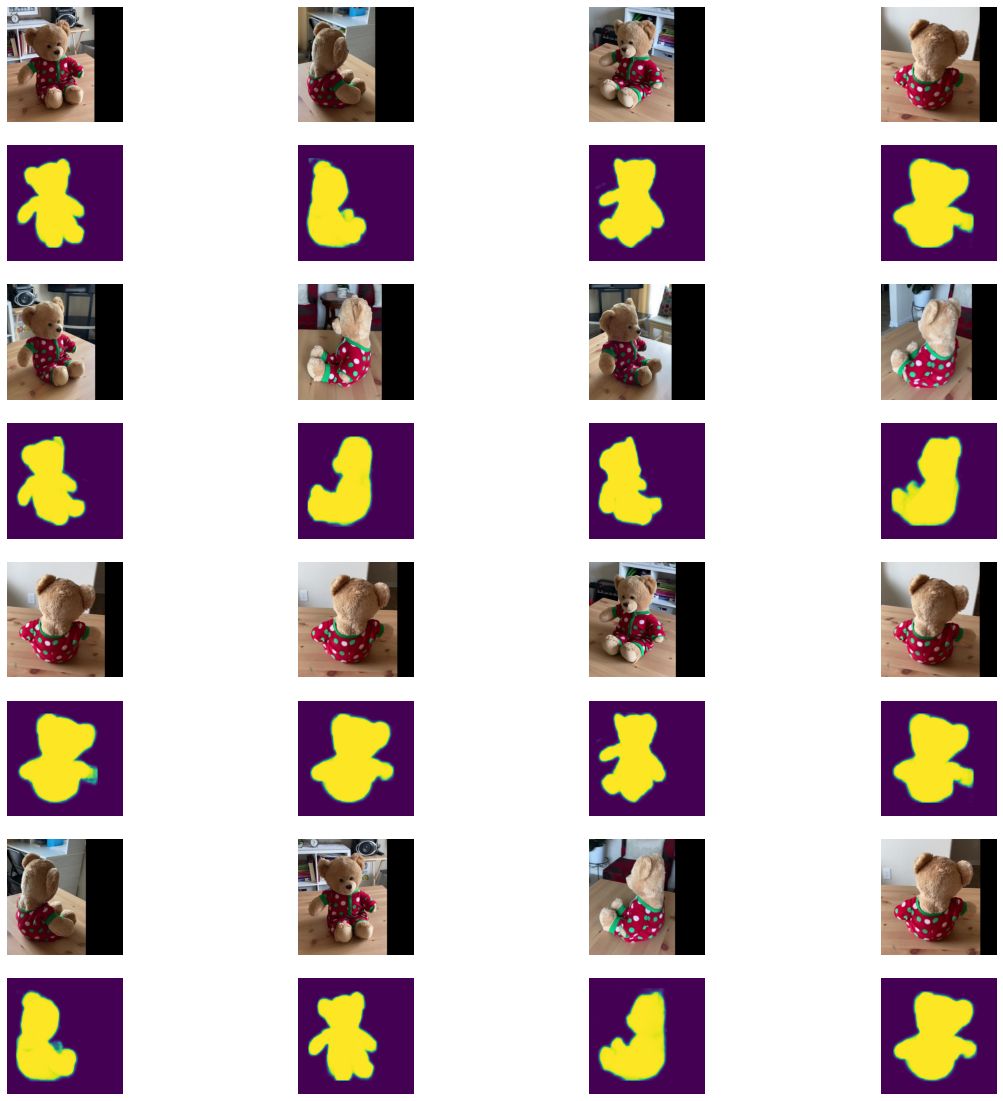

In [12]:
plt.figure(figsize=(20, 20))

for idx, data in enumerate(train_loader):
    imgs = data.image_rgb
    masks = data.fg_probability
    
    for i, (img, mask) in enumerate(zip(imgs, masks)):
        plt.subplot(8, 4, 8*idx + (i + 1))
        img = img.numpy().transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(8, 4, 8*idx + (i + 1) + 4)
        mask = mask.numpy().transpose(1, 2, 0)
        plt.imshow(mask)
        plt.axis("off")

    if idx == 3:
        break

## Model 객체 생성

In [8]:
resnet_feature_dim = 32 * 3
rgb_dim = 3
segemtation_dim = 1
pe_dim = 10

d_z = resnet_feature_dim + rgb_dim + segemtation_dim + pe_dim*2*3
print(f"D_z: {d_z}")

D_z: 160


In [9]:
net = NerFormer(d_z=d_z).to(device)

In [10]:
feature_net = FeatureNet().to(device)

In [17]:
!nvidia-smi

Tue Nov 30 15:59:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:60:00.0 Off |                  N/A |
| 27%   29C    P2    52W / 250W |    984MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Criterion

In [11]:
mse_loss = nn.MSELoss()         # target RGB <-> GT RGB
bce_loss = nn.BCELoss()         # target Mask <-> GT Mask

tb_dir = os.path.join(root_dir, 'logs/', exp_name)
writer = SummaryWriter(tb_dir)
print('saving tensorboard files to {}'.format(tb_dir))

scalars_to_log = {}

saving tensorboard files to ./logs/test_exp


In [12]:
learning_rate = 5e-4

ray_sampling_mode = "center"

n_iters = 5000
global_step = 0
epoch = 0

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [14]:
print_loss_step = 100
save_checkpoint_step = 1000
save_val_img_step = 500

In [26]:
target_idx = 0
sources = [src_idx for src_idx in range(1, N_src + 1)]

PE = HarmonicEmbedding(n_harmonic_functions=pe_dim).to(device)

while global_step < n_iters + 1:
    for train_data in train_loader:
        time0 = time.time()
        
        ##################### target, source data frame 구성 #####################
        target, srcs = data_to_frame(train_data, device, target_idx, sources)

        ######################## source feature map 구성 ########################
        with torch.no_grad():
            feature_maps = feature_net(srcs["rgb"], srcs["mask"])
            print(feature_maps.shape)

        # ray sampler 생성
        ray_sampler = RaySampler(target, target_idx, device)
        # 타겟 이미지에서 N_rays개의 ray 샘플링
        ray_batch = ray_sampler.random_sample(N_rays, ray_sampling_mode)

        output = render_rays(ray_batch, net, net, feature_maps, sources, N_s, PE, N_importance=5)

        optimizer.zero_grad()

        coarse_rgb_loss = mse_loss(output["outputs_coarse"]["rgb"], ray_batch["rgb"])
        coarse_mask_loss = bce_loss(output["outputs_coarse"]["mask"][..., 0], ray_batch["mask"])

        coarse_loss = coarse_rgb_loss + coarse_mask_loss

        fine_rgb_loss = mse_loss(output["outputs_fine"]["rgb"], ray_batch["rgb"])
        fine_mask_loss = bce_loss(output["outputs_fine"]["mask"][..., 0], ray_batch["mask"])

        fine_loss = fine_rgb_loss + fine_mask_loss

        total_loss = coarse_loss + fine_mask_loss
        total_loss.backward()

        scalars_to_log['loss'] = total_loss.item()
        
        optimizer.step()

        dt = time.time() - time0

        # loss 출력
        if global_step % print_loss_step == 0 or global_step < 10:
            scalars_to_log['train/coarse-rgb-loss'] = coarse_rgb_loss
            scalars_to_log['train/coarse-mask-loss'] = coarse_mask_loss

            if output['outputs_fine'] is not None:
                scalars_to_log['train/fine-rgb-loss'] = fine_rgb_loss
                scalars_to_log['train/fine_mask_loss'] = fine_mask_loss

            logstr = '{} Epoch: {}  step: {} '.format(exp_name, epoch, global_step)
            for k in scalars_to_log.keys():
                logstr += ' {}: {:.6f}'.format(k, scalars_to_log[k])
                writer.add_scalar(k, scalars_to_log[k], global_step)
            print(logstr)
            print('each iter time {:.05f} seconds'.format(dt))

        # checkpoint 저장
        if global_step % save_checkpoint_step == 0:
            print(f"Step[{global_step+1}/{n_iters+1}]: Checkpoint 저장...")
            save_path = os.path.join(out_folder, "model_{:06d}.pth".format(global_step))

            to_save = {
                        'optimizer': optimizer.state_dict(),
                        'net': net.state_dict(),
                        }
            torch.save(to_save, save_path)

        # validation 시각화 저장
        if global_step % save_val_img_step == 0:
            ######################## random validation data ########################
            print(f"Step[{global_step+1}/{n_iters+1}]: Validation data 결과 저장...")

            val_data = next(iter(val_loader))
            #  validation target, source data frame 구성 
            val_target, val_srcs = data_to_frame(val_data, device, target_idx, sources)
            # validation ray sampler 생성
            val_ray_sampler = RaySampler(val_target, target_idx, device, render_stride=1)
            H, W = val_ray_sampler.H, val_ray_sampler.W
            val_gt_img = val_ray_sampler.rgb.reshape(H, W, 3)
            # log
            log_view_to_tensorboard(writer, global_step, net, val_ray_sampler,
                                   val_srcs, sources, val_gt_img, render_stride=1, prefix='val/')

            ######################## current training data ########################
            print(f"Step[{global_step+1}/{n_iters+1}]: Training data 결과 저장...")

            # train ray sampler 생성
            train_ray_sampler = RaySampler(target, target_idx, device, render_stride=1)
            H, W = train_ray_sampler.H, train_ray_sampler.W
            train_gt_img = train_ray_sampler.rgb.reshape(H, W, 3)
            # log
            log_view_to_tensorboard(writer, global_step, net, train_ray_sampler,
                                   srcs, sources, train_gt_img, render_stride=1, prefix='train/')
    


        global_step += 1

        if global_step > n_iters + 1:
            break
        
    epoch += 1

torch.Size([3, 100, 800, 800])
test_exp Epoch: 0  step: 0  loss: 113.095306 train/coarse-rgb-loss: 0.180601 train/coarse-mask-loss: 56.457352 train/fine-rgb-loss: 0.180547 train/fine_mask_loss: 56.457352
each iter time 0.48491 seconds
Step[1/11]: Checkpoint 저장...
Step[1/11]: Validation data 결과 저장...
Step[1/11]: Training data 결과 저장...
torch.Size([3, 100, 800, 800])
test_exp Epoch: 0  step: 1  loss: 114.196632 train/coarse-rgb-loss: 0.155464 train/coarse-mask-loss: 57.020584 train/fine-rgb-loss: 0.154453 train/fine_mask_loss: 57.020584
each iter time 1.07993 seconds
torch.Size([3, 100, 800, 800])
test_exp Epoch: 0  step: 2  loss: 117.417686 train/coarse-rgb-loss: 0.172594 train/coarse-mask-loss: 58.622547 train/fine-rgb-loss: 0.171126 train/fine_mask_loss: 58.622547
each iter time 0.27863 seconds
torch.Size([3, 100, 800, 800])
test_exp Epoch: 0  step: 3  loss: 126.189987 train/coarse-rgb-loss: 0.129207 train/coarse-mask-loss: 63.030388 train/fine-rgb-loss: 0.128100 train/fine_mask_loss: 

In [138]:
from pytorch3d.renderer import EmissionAbsorptionRaymarcher

In [139]:
ea_raymarching = EmissionAbsorptionRaymarcher()

In [153]:
output = ea_raymarching(f_o, f_c)

/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/pytorch3d/renderer/implicit/raymarching.py:187: UserWarning: One or more elements of rays_densities are outside of validrange (0.0, 1.0)
  warnings.warn(


In [154]:
print(output.shape)

print(f"ray features = {output[:, :3]}")
print(f"ray opacity = {output[:, 3]}")

torch.Size([5, 4])
ray features = tensor([[  0.1367,   1.0192,  -0.1217],
        [ 17.5993,  63.9547,   6.8575],
        [ 15.1883, -52.7497,  -1.1623],
        [  1.1578,   0.0795,  -1.1071],
        [ -1.3059,   0.9600,   2.4288]])
ray opacity = tensor([ 1.0000, -0.0420,  0.9882,  0.9997,  1.0000])


In [19]:
data = next(iter(train_loader))

In [20]:
data.image_rgb.shape

torch.Size([4, 3, 800, 800])

In [21]:
target = {}
target["rgb"] = data.image_rgb[0]
target["rgb_path"] = data.image_path[0]
target["camera"] = data.camera

In [22]:
ray_sampler = RaySampler(target, 0, device, resize_factor=1, render_stride=1)

In [23]:
ret = ray_sampler.random_sample(N_rays, "center")

sampling_ray_d = ret["ray_d"]
sampling_ray_o = ret["ray_o"]

In [24]:
camera_position = data.camera.get_camera_center()[0].cpu()
print('\n', camera_position)


 tensor([-8.2352, -2.8867, -3.1218])


In [25]:
near = np.linalg.norm(camera_position) - 8
far = np.linalg.norm(camera_position) + 8

depth_range =  torch.tensor([near, far], dtype=torch.float32)
print(depth_range)

tensor([ 1.2680, 17.2680])


In [26]:
pts, z_vals = sample_along_camera_ray(sampling_ray_o, sampling_ray_d, depth_range,
                            N_s,
                            inv_uniform=False,
                            det=True)

print(pts.shape, z_vals.shape)

torch.Size([10, 30, 3]) torch.Size([10, 30])


In [31]:
pts.shape

torch.Size([10, 30, 3])

In [32]:
proj_points = data.camera.transform_points_screen(pts.reshape(-1, 3), image_size=(800, 800))

In [36]:
proj_points[1:].reshape(-1, 10, 30, 3).shape

torch.Size([3, 10, 30, 3])

In [81]:
ray_batch = {}
ray_batch["ray_o"] = sampling_ray_o
ray_batch["ray_d"] = sampling_ray_d
ray_batch["depth_range"] = depth_range
ray_batch["camera"] = data.camera

In [82]:
ray_batch["camera"].R

tensor([[[-0.1942,  0.5264,  0.8278],
         [-0.4203, -0.8071,  0.4147],
         [ 0.8864, -0.2674,  0.3779]],

        [[ 0.9185,  0.2217,  0.3274],
         [-0.1657, -0.5359,  0.8278],
         [ 0.3591, -0.8146, -0.4555]],

        [[-0.9814, -0.1446, -0.1262],
         [ 0.1329, -0.9864,  0.0970],
         [-0.1385,  0.0784,  0.9872]],

        [[ 0.5698,  0.4376,  0.6956],
         [-0.3693, -0.6198,  0.6924],
         [ 0.7342, -0.6514, -0.1916]]], device='cuda:0')

In [83]:
img_feature.shape

torch.Size([3, 100, 800, 800])

In [74]:
sources = [1, 2, 3]
pts_pe = pe(pts)

input_tensor = feature_sampling(img_feature, data.camera, pts, pts_pe, (800, 800), sources)

In [75]:
input_tensor.shape

torch.Size([10, 30, 3, 160])

In [77]:
output = net(input_tensor)

In [79]:
output[0].shape

torch.Size([10, 30, 1])

In [80]:
output[1].shape

torch.Size([10, 30, 3])

In [54]:
screen_to_ndc = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(data.camera, image_size=(800, 800), with_xyflip=True).to(device)

src1_screen_to_ndc = screen_to_ndc[1]
src2_screen_to_ndc = screen_to_ndc[2]
src3_screen_to_ndc = screen_to_ndc[3]

src1_proj_ndc = src1_screen_to_ndc.transform_points(src_proj_points[0])
src2_proj_ndc = src2_screen_to_ndc.transform_points(src_proj_points[1])
src3_proj_ndc = src3_screen_to_ndc.transform_points(src_proj_points[2])

In [56]:
src_proj_ndc = torch.stack([src1_proj_ndc, src2_proj_ndc, src3_proj_ndc], dim=0)[..., :2]

In [60]:
sampling_features = F.grid_sample(src_img_features, src_proj_ndc, align_corners=False, padding_mode="zeros", mode='bilinear')

print(sampling_features.shape)

torch.Size([3, 99, 10, 30])


In [62]:
input_tensor = sampling_features.permute(2, 3, 0, 1)

print(input_tensor.shape)

torch.Size([10, 30, 3, 99])


In [66]:
ray_densities, ray_colors = net(input_tensor)

In [67]:
print(ray_densities.shape, ray_colors.shape)

torch.Size([10, 30, 1]) torch.Size([10, 30, 3])


In [86]:
rays_output = EARayMarching(z_vals, ray_densities, ray_colors)

In [88]:
rays_output.keys()

dict_keys(['rays_color', 'weights', 'alphas'])

In [89]:
rays_output["rgb"].shape

torch.Size([10, 3])

In [90]:
rays_output["weights"].shape

torch.Size([10, 30])

In [91]:
rays_output["alphas"].shape

torch.Size([10, 30])

In [110]:
# delta 계산
delta = z_vals[..., 1:] - z_vals[..., :-1]      # (N_rays, samples-1)
delta = torch.cat((delta, delta[..., -1:]), dim=-1)     # (N_rays, samples)

print(delta.shape)
print(delta[0])

torch.Size([10, 30])
tensor([0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517,
        0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517,
        0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517, 0.5517,
        0.5517, 0.5517, 0.5517], device='cuda:0')


In [134]:
ray_densities = output[0]
ray_colors = output[1]

print(ray_densities.shape)
print(ray_colors.shape)

torch.Size([10, 30, 1])
torch.Size([10, 30, 3])


In [124]:
# alpha 계산
T = torch.exp(-delta * ray_densities[..., 0])
alphas = 1 - T + 1e-10

# absorption 계산
absorption = torch.cumprod(T, dim=1)

# weights
weights = absorption * alphas        # importance sample을 추출하는 fine 단계에서 사용한다.

In [135]:
# color 계산
colors = torch.sum(weights.unsqueeze(2) * ray_colors, dim=-2)    # (N_rays, 3)

# depth_map = torch.sum(wegihts * z_vals, dim=-1)

# mask 계산
masks = 1 - torch.prod((1 - T), dim=1)

In [145]:
colors.shape

torch.Size([10, 3])

In [136]:
masks.shape

torch.Size([10])

In [149]:
torch.sum(weights.unsqueeze(2) * ray_colors, dim=-2)

tensor([[-0.0208,  0.1484,  0.0348],
        [ 0.0086,  0.1139,  0.0441],
        [-0.0293,  0.1880,  0.1008],
        [-0.0059,  0.1563,  0.0349],
        [-0.0041,  0.1355,  0.0619],
        [ 0.0106,  0.1358,  0.0545],
        [-0.0115,  0.1137,  0.0709],
        [-0.0226,  0.1614,  0.0509],
        [-0.0363,  0.1105,  0.0506],
        [-0.0235,  0.1884,  0.0728]], device='cuda:0', grad_fn=<SumBackward1>)

In [159]:
masks = 1 - torch.prod((1 - T), dim=1, keepdim=True)

In [160]:
masks.shape

torch.Size([10, 1])

In [161]:
masks = 1 - torch.prod((1 - T), dim=0)

In [162]:
masks.shape

torch.Size([30])

In [169]:
ret["outputs_coarse"]["alphas"].shape

torch.Size([10, 30])